In [1]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

In [2]:
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

X_train = df_train.Text
X_test = df_test.Text

y_train = df_train.Emotion
y_test = df_test.Emotion

# Define the updated class names
class_names = ['joy', 'sadness', 'fear', 'anger', 'surprise', 'neutral', 'disgust', 'shame', 'guilt']

# Concatenate training and test sets for data exploration
data = pd.concat([df_train, df_test])

print('Number of different values in the \'emotion\' column: %d' % len(data.Emotion.unique()))
print('\nDifferent values and their counts in the \'emotion\' column:')
print(data.Emotion.value_counts())

data.head()


Number of different values in the 'emotion' column: 9

Different values and their counts in the 'emotion' column:
joy         12605
sadness      8364
fear         6914
anger        5851
surprise     4275
neutral      2254
disgust      2018
shame        1346
guilt        1052
Name: Emotion, dtype: int64


,Text,Emotion
0,Such as ?,neutral
1,I felt angry when I saw on T.V the last slaugh...,anger
2,Home from a long fun day with my girls @ colle...,joy
3,Apparently everyone at work but me knew it was...,surprise
4,"“@RevRunWisdom: not afraid of tomorrow, for I ...",fear


In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [4]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

In [5]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.Text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

Accuracy: 48.96%

F1 Score: 48.96

COnfusion Matrix:
 [[ 552    0    6    0 1066    0   94    0    0]
 [  27    1   10    0  519    0   36    0    0]
 [   3    0  945    0 1073    0   81    0    7]
 [  20    0    5    0  246    0   58    0    0]
 [   0    0    5    0 3705    1   28    0   14]
 [   3    0    3    0  563   85   44    0    0]
 [   7    0   12    0 1436    0 1084    0    2]
 [  14    0    5    0  347    0   37    0    0]
 [   2    0   21    0 1012    0   34    0  191]]


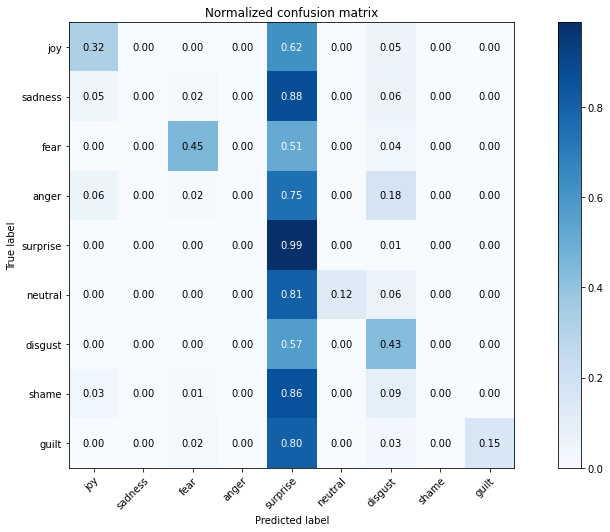

In [6]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Accuracy: 64.43%

F1 Score: 64.43

COnfusion Matrix:
 [[1054    2   15    0  493   29  120    0    5]
 [  68  121   24    2  315    6   50    3    4]
 [  27    5 1485    2  445   18   96    2   29]
 [  59    2   21   50  130    3   63    1    0]
 [  23    0   32    0 3502   57  115    0   24]
 [   7    0    9    0  154  487   41    0    0]
 [  40    4   30    0  972   30 1453    0   12]
 [  51    0   26    6  139    2   49  130    0]
 [  25    0   22    0  730   26  102    1  354]]


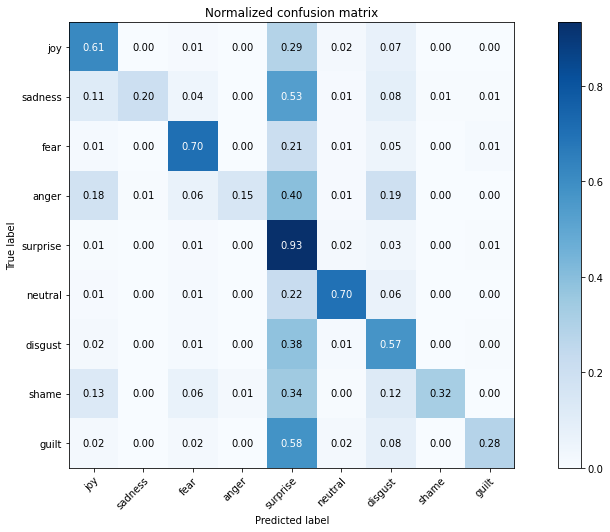

In [7]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 64.93%

F1 Score: 64.93

COnfusion Matrix:
 [[1114    9   47    1  328   12  195    0   12]
 [ 117  124   57    1  200    1   83    3    7]
 [  65    4 1449    2  397    2  139    6   45]
 [ 107    2   22   66   53    0   69    9    1]
 [  50    0   53    1 3361   41  189    1   57]
 [  32    0   20    0  216  344   73    0   13]
 [ 109    3   78    1  666   13 1637    1   33]
 [  65    3   40   11  104    0   51  128    1]
 [  52    0   45    0  569    4  109    1  480]]


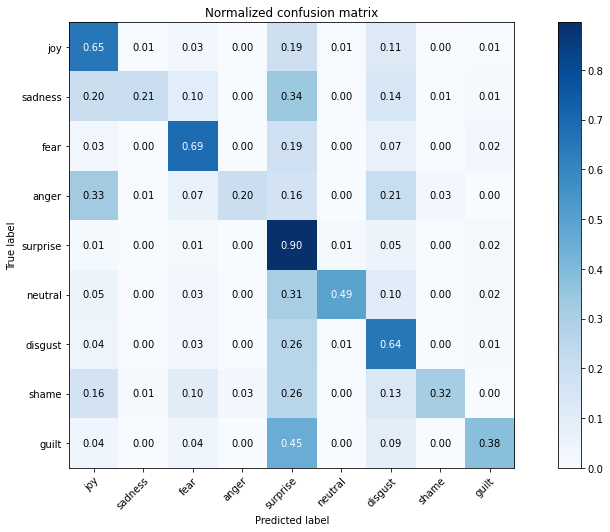

In [8]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Accuracy: 70.00%

F1 Score: 70.00

COnfusion Matrix:
 [[1227   11   39    3  214   25  161    3   35]
 [ 102  221   43    9  112    3   68   15   20]
 [  60   10 1631    8  200    8  129    6   57]
 [  76    5   23  121   26    1   50   24    3]
 [  74   11   75    0 3185   85  201    3  119]
 [  26    2   21    1  136  439   59    0   14]
 [ 111   14   85    7  463   38 1742    3   78]
 [  43   13   23   30   52    1   38  201    2]
 [  61    6   46    0  406   15  107    3  616]]


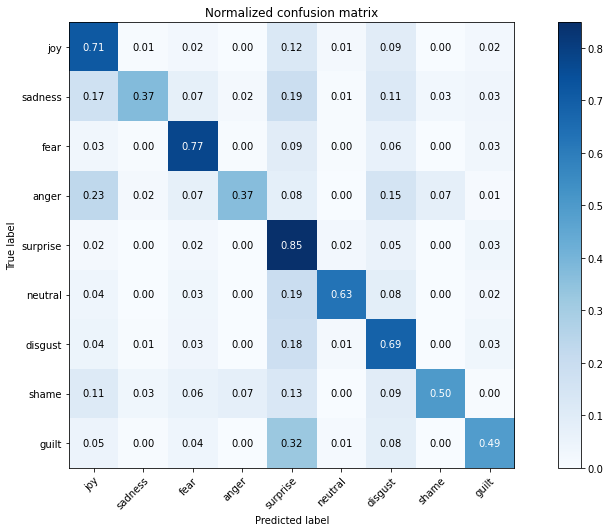

In [9]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [10]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [11]:
# save the model
filename = 'models/tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [12]:
model = pickle.load(open(filename, 'rb'))

message = 'delivery was hour late and my pizza is cold!' 
model.predict([message])

array(['anger'], dtype=object)